# Plot fields for one DYAMOND model

## Import Packages

In [54]:
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import typhon
import cartopy.crs as ccrs
import processing_tools
from netCDF4 import Dataset
from os.path import join
import analysis_tools as atools
%matplotlib inline    

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


## Read Temperature, Pressure, Specific humidity 

In [ ]:
# config
model = 'ICON'
run = '5.0km_2'
variables = ['QV', 'TEMP', 'PRES']
datapath = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/{}'.format(model)

In [4]:
# read variables
field = dict.fromkeys(variables)
for var in variables:
    filename = f'{model}-{run}_{var}_hinterp_timeaverage_vinterp.nc'
    field[var] = atools.read_var(join(datapath, filename), var)

# read latitudes and longitudes
lat = atools.read_var(join(datapath, filename), 'lat')
lon = atools.read_var(join(datapath, filename), 'lon')
height = atools.read_var(join(datapath, filename), 'zlev')

## Calculate RH

In [55]:
# calculate relative humidity (equilibrium water vapour with respect to mixed-phase and water)
field['RH'] = atools.spec_hum2rel_hum(field['QV'], field['TEMP'], field['PRES'], phase='mixed')
field['RH_W'] = atools.spec_hum2rel_hum(field['QV'], field['TEMP'], field['PRES'], phase='water')

/mnt/lustre02/work/um0878/users/tlang/dev/typhon/typhon/physics/thermodynamics.py:94: RuntimeWarning: invalid value encountered in less_equal
  if np.any(T <= 0):
/mnt/lustre02/work/um0878/users/tlang/dev/typhon/typhon/physics/thermodynamics.py:54: RuntimeWarning: invalid value encountered in less_equal
  if np.any(T <= 0):
/mnt/lustre02/work/um0878/users/tlang/dev/typhon/typhon/physics/thermodynamics.py:172: RuntimeWarning: invalid value encountered in greater
  is_water = T > constants.triple_point_water
/mnt/lustre02/work/um0878/users/tlang/dev/typhon/typhon/physics/thermodynamics.py:174: RuntimeWarning: invalid value encountered in less
  is_ice = T < (constants.triple_point_water - 23.)


[[[478.032    478.03073  478.03073  ... 478.03336  478.032    478.032   ]
  [480.45288  480.4511   480.45212  ... 480.45956  480.45648  480.45654 ]
  [482.52078  482.5172   482.51416  ... 482.53024  482.52924  482.525   ]
  ...
  [255.37976  255.38033  255.38118  ... 255.37674  255.37738  255.37914 ]
  [255.1696   255.1696   255.17023  ... 255.16808  255.16808  255.16913 ]
  [255.07318  255.07318  255.07318  ... 255.07318  255.07318  255.07318 ]]

 [[306.97586  306.9754   306.9754   ... 306.97653  306.97653  306.97586 ]
  [307.30826  307.30704  307.30582  ... 307.3121   307.3106   307.3093  ]
  [307.79242  307.79153  307.7904   ... 307.7963   307.79547  307.79315 ]
  ...
  [170.87242  170.87242  170.87201  ... 170.87361  170.87315  170.87315 ]
  [170.4993   170.4993   170.4993   ... 170.49966  170.4993   170.4993  ]
  [170.0431   170.0431   170.0431   ... 170.0431   170.0431   170.0431  ]]

 [[187.11282  187.11282  187.11282  ... 187.11362  187.11362  187.11362 ]
  [187.50392  187.5039

## Calculate averages

In [42]:
# Calculate different averages
variables.append('RH')
variables.append('RH_W')
zonmean = dict.fromkeys(variables)
meanprofile_tropics = dict.fromkeys(variables)
for var in variables:
    zonmean[var] = atools.calc_zonal_mean(field[var])
    meanprofile_tropics[var] = atools.calc_mean_profile_for_area(field[var], lat, lon, [-30, 30], [-180, 180])

/mnt/lustre02/work/um0878/users/tlang/work/dyamond/analysis/analysis_tools.py:68: RuntimeWarning: Mean of empty slice
  return np.nanmean(field, axis=axis)


## Plot

### Zonal mean specific humidity

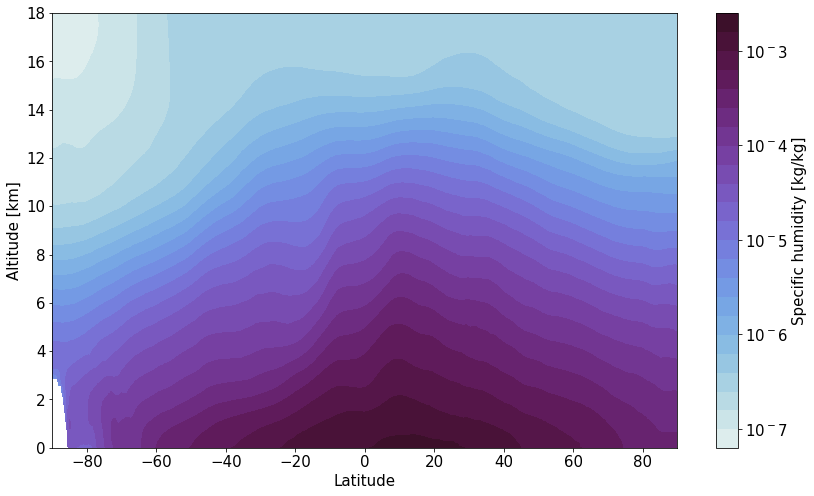

In [47]:
# plot zonal mean specific humidity
plt.rcParams.update({'font.size': 15})
la, hi = np.meshgrid(lat, height)
fig, ax = plt.subplots(figsize=(14, 8))
#im = ax.pcolormesh(la, hi * 1e-3, np.log10(zonmean['QV']), cmap='density')
im = ax.contourf(lat, height * 1e-3, np.log10(zonmean['QV']), 26, cmap='density')
ax.set_ylim(0, 18)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude [km]')

ticks = np.asarray([1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
tick_labels = ['10$^{:.0f}$'.format(i) for i in np.log10(ticks)]
log_ticks = np.log10(ticks)
cb = fig.colorbar(im, ticks=log_ticks)
cb.ax.set_yticklabels(tick_labels)
cb.set_label('Specific humidity [kg/kg]')


### Zonal mean temperature

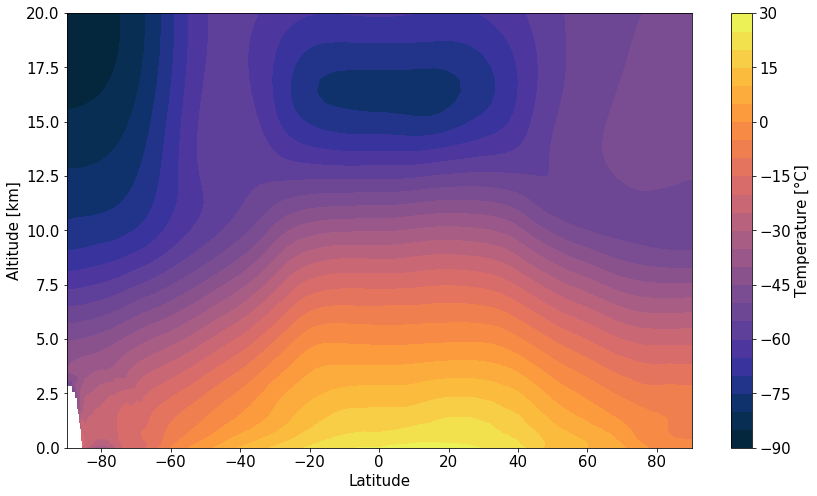

In [50]:
# plot zonal mean temperature
plt.rcParams.update({'font.size': 15})
la, hi = np.meshgrid(lat, height)
fig, ax = plt.subplots(figsize=(14, 8))
#im = ax.pcolormesh(la, hi * 1e-3, zonmean['TEMP'] - 273.15, cmap='temperature')
im = ax.contourf(lat, height * 1e-3, zonmean['TEMP'] - 273.15, 26, cmap='temperature')
ax.set_ylim(0, 20)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude [km]')

cb = fig.colorbar(im)
cb.set_label('Temperature [°C]')

### Zonal mean specific humidity

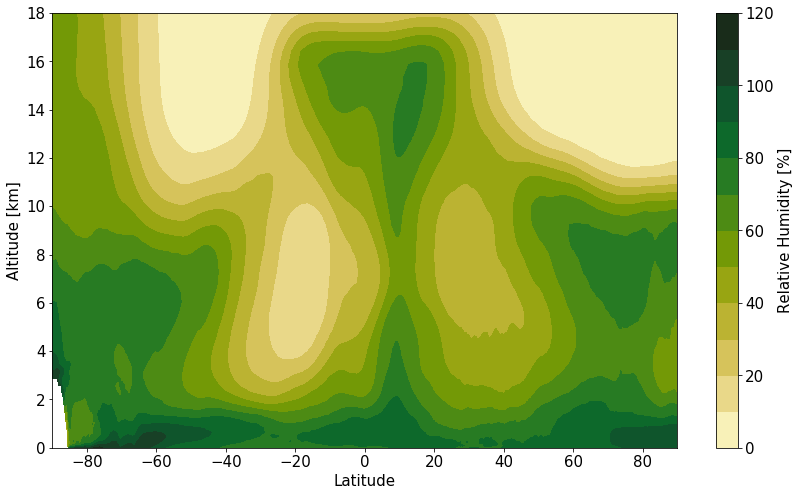

In [57]:
# plot zonal mean relative humidity
plt.rcParams.update({'font.size': 15})
la, hi = np.meshgrid(lat, height)
fig, ax = plt.subplots(figsize=(14, 8))
#im = ax.pcolormesh(la, hi * 1e-3, zonmean['RH'] * 1e2, cmap='speed')
im = ax.contourf(lat, height * 1e-3, zonmean['RH'] * 1e2, 13, cmap='speed')
ax.set_ylim(0, 18)
#ax.set_xlim(-30, 30)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude [km]')

cb = fig.colorbar(im)
cb.set_label('Relative Humidity [%]')

### Tropical mean profiles of temperature, specific humidity and relative humidity

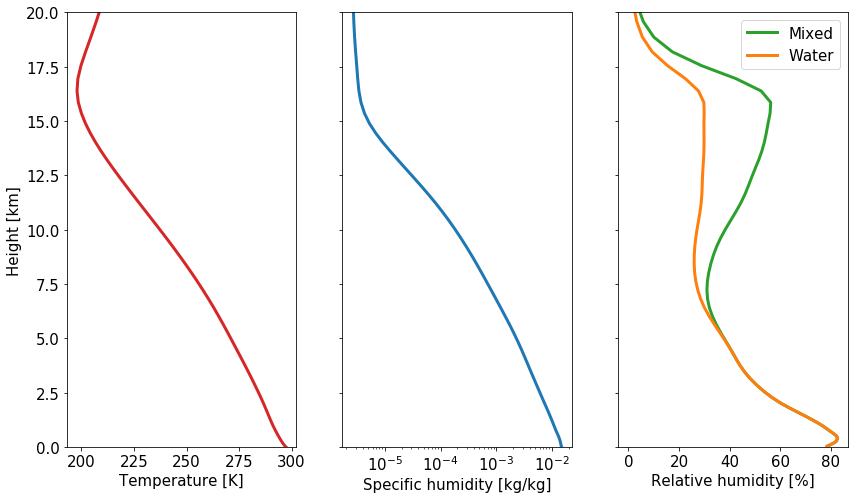

In [52]:
# plot tropical mean profiles of temperature, specific humidity and relative humidity

fig, ax = plt.subplots(1, 3, figsize=(14, 8), sharey=True)
ax[0].plot(meanprofile_tropics['TEMP'], height * 1e-3, lw=3, color='C3')
ax[1].semilogx(meanprofile_tropics['QV'], height * 1e-3, lw=3, color='C0')
ax[2].plot(meanprofile_tropics['RH'] * 1e2, height * 1e-3, lw=3, color='C2', label='Mixed')
ax[2].plot(meanprofile_tropics['RH_W'] * 1e2, height * 1e-3, lw=3, color='C1', label='Water')

ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Specific humidity [kg/kg]')
ax[2].set_xlabel('Relative humidity [%]')

ax[2].legend()
